In [1]:
import os
import json

from tqdm import tqdm
from tqdm import trange

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm as cm_matplot
from matplotlib.colorbar import make_axes

import mygene

import sys
sys.path.insert(1, '../')
from utils import read_pickled_object

In [2]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 3

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [3]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)
rna_cols = X.columns
X = X.values


y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)['mean'].values.ravel()

best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 
                                                 'best_model.pickle'))
best_pipeline

Pipeline(steps=[('feature_reduction', FeatureSelector(n_features=19138)),
                ('mean_centering', MeanCenterer()),
                ('model',
                 SVR(C=np.float64(0.12405950756148096),
                     epsilon=np.float64(0.7247779323323353),
                     kernel='linear'))])

ID mapping between protein and RNA:

Fit on the full dataset:

In [7]:
best_pipeline.fit(X, y)
model_coefs = best_pipeline.named_steps['model'].coef_.flatten()

/tmp/ipykernel_1644029/2709409219.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha = 'center')


''

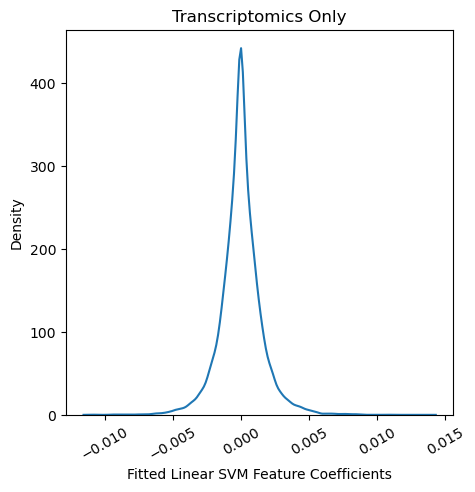

In [9]:
fig, ax = plt.subplots(figsize = (5,5))

sns.kdeplot(model_coefs, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha = 'center')
ax.set_xlabel('Fitted Linear SVM Feature Coefficients')
ax.set_title('Transcriptomics Only')
;


Let's take a look at the top 500 features:

array([ 2748,  4931,  6564, ..., 15017, 13480,  4319])

In [17]:
rna_indices = best_pipeline.named_steps['feature_reduction'].top_indices_
selected_cols = [rna_cols[i] for i in rna_indices]

model_coefs = best_pipeline.named_steps['model'].coef_.flatten()
model_coefs = pd.DataFrame(data = {'SVM coefficient': model_coefs}, 
                           index = selected_cols)

top_n = 500
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.reset_index(names = 'Feature Name', inplace = True)
top_model_coefs = model_coefs.iloc[:top_n, :]
# top_model_coefs.reset_index(names = 'Feature Name', inplace = True)


''

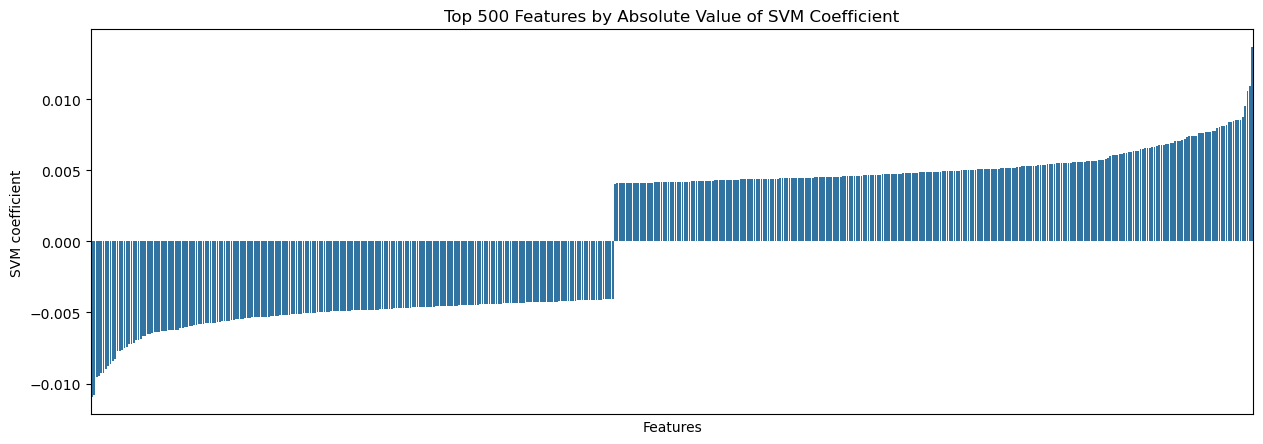

In [20]:
fig, ax = plt.subplots(figsize = (15, 5))

viz_df = top_model_coefs.sort_values(by = 'SVM coefficient', ascending = True)
sns.barplot(data = viz_df, x = 'Feature Name', y = 'SVM coefficient',
            ax = ax)
ax.set_xticklabels([])
ax.set_title('Top 500 Features by Absolute Value of SVM Coefficient')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_xlabel('Features')
;

## ORA

We will run ORA on the positive and negative coefficients from the top 500 features separately. 

In [41]:
model_coefs['Gene Name'] = model_coefs['Feature Name'].apply(lambda x: x.split(' (')[0])

top_model_coefs = model_coefs.iloc[:top_n].copy()
neg_top = top_model_coefs[top_model_coefs['SVM coefficient'] < 0]
pos_top = top_model_coefs[top_model_coefs['SVM coefficient'] > 0]

background = model_coefs['Gene Name']
# prepare for metascape input
for col_name, gene_list in {'negative': neg_top, 'positive': pos_top}.items():
    mi = pd.DataFrame(data = {'_BACKGROUND': background})

    goi = gene_list['Gene Name'].tolist()
    mi[col_name] = goi + [np.nan]*(len(background)- len(goi))
    
    mi.set_index('_BACKGROUND', inplace = True)
    mi.to_csv(os.path.join(data_path, 'interim/', col_name + '_transcriptomics_metascape_input.csv'))

Load and format metascape output:

In [44]:
mss = {}
sort_by = 'pval' #'zscore'
for key in ['negative', 'positive']:
    ms = pd.read_excel(os.path.join(data_path, 'processed', key + '_transcriptomics_metascape_result.xlsx'), 
                           sheet_name = 'Enrichment',
                           index_col = None)
    ms_all = pd.read_csv(os.path.join(data_path, 'processed', key + '_transcriptomics_GO_AllLists.csv'), 
                        index_col = 0)

    # get average z-score per summary term from the individual members
    ms_members = ms[ms['GroupID'].apply(lambda x: x.endswith('_Member'))].copy()
    if ms_members.Term.nunique() != ms_members.shape[0]:
        raise ValueError('Expected unique terms')

    zscores = []
    for term in ms_members.Term:
        ms_term = ms_all[ms_all.GO == term]
        if ms_term.shape[0] != 1:
            raise ValueError('Expected 1 unique term')
        zscores.append(ms_term['Z-score'].values.tolist()[0])
    ms_members['Z-score'] = zscores

    term_zscore = ms_members.groupby('GroupID')['Z-score'].mean().to_dict()
    term_zscore = {k.split('_')[0]:v for k,v in term_zscore.items()}

    ms = ms[ms['GroupID'].apply(lambda x: x.endswith('_Summary'))]
    ms.reset_index(drop = True, inplace = True)
    ms['Z-score'] = ms['GroupID'].apply(lambda x: term_zscore[x.split('_')[0]])
    
    
    # formatting
    ms['q-value'] = 10**ms['Log(q-value)']
    ms = ms[ms['q-value'] <= 0.1]
    ms['-Log10(q-value)'] = -ms['Log(q-value)']
    if ms['Z-score'].min() < 0:
        raise ValueError('Sorted according to assumption that all Z-scores to be positive')
    if sort_by == 'zscore':
        ms.sort_values(by = ['Z-score','Log(q-value)'], ascending=[False, True], inplace = True) 
    elif sort_by == 'pval':
        # sort by q-value, tie break with z-score
        ms.sort_values(by = ['Log(q-value)', 'Z-score'], ascending=[True, False], inplace = True) 
    else:
        raise ValueError('Specificy a sort column')

    ms.reset_index(drop = True, inplace = True)
    mss[key] = ms

In [45]:
def middle_break(my_string, len_thresh):
    if len(my_string) >= len_thresh:
        middle_index = len(my_string) // 2

        space_before = my_string.rfind(' ', 0, middle_index)  
        space_after = my_string.find(' ', middle_index)       

        # Choose the nearest space
        if space_before == -1:  
            break_index = space_after
        elif space_after == -1:  
            break_index = space_before
        else:  
            break_index = space_before if middle_index - space_before <= space_after - middle_index else space_after

        new_string = my_string[:break_index] + '\n' + my_string[break_index + 1:]
    else:
        new_string = my_string

    return new_string


/tmp/ipykernel_1644029/2097599675.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm_matplot.get_cmap('YlOrBr_r')
/tmp/ipykernel_1644029/2097599675.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = ms_topn, x = 'Description', y = y_col,
/tmp/ipykernel_1644029/2097599675.py:26: UserWarning: The palette list has more values (20) than needed (10), which may not be intended.
  sns.barplot(data = ms_topn, x = 'Description', y = y_col,
/tmp/ipykernel_1644029/2097599675.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels,
/tmp/ipykernel_1

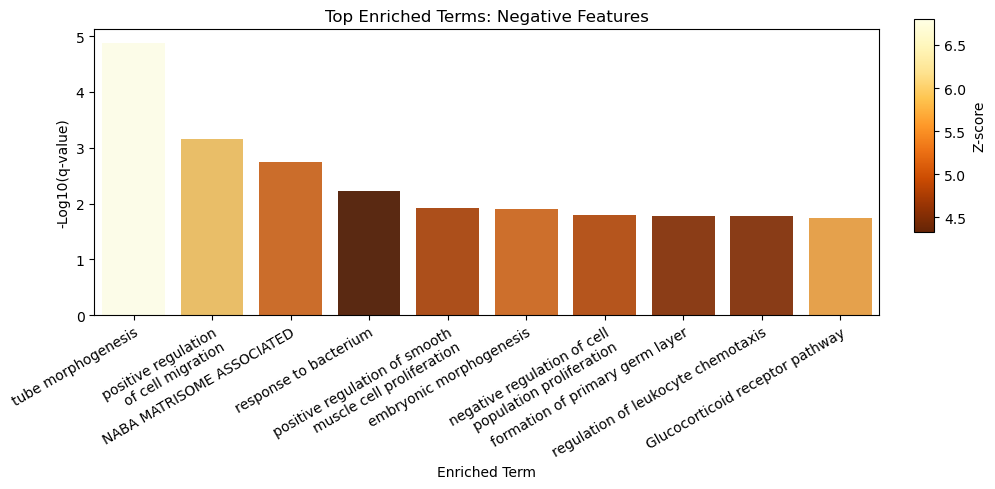

In [46]:
fig, ax = plt.subplots(figsize = (10, 5))

key = 'negative'
top_n = 10
ms = mss[key]
ms_topn = ms.iloc[:top_n, :]

if sort_by == 'zscore':
    color_col = '-Log10(q-value)'
    y_col = 'Z-score'
elif sort_by == 'pval':
    color_col = 'Z-score' 
    y_col = '-Log10(q-value)'
norm = Normalize(vmin=ms_topn[color_col].min(), vmax=ms_topn[color_col].max())
cmap = cm_matplot.get_cmap('YlOrBr_r')
colors = [cmap(norm(val)) for val in ms[color_col]]
cbar_ax = fig.add_axes([0.92, 0.525, 0.02, 0.425])  # [left, bottom, width, height]
# pos = ax.get_position()  # Returns a Bbox object
# cbar_width = 0.02  # Width of the colorbar
# cbar_padding = 0.02  # Space between subplot and colorbar
# cbar_ax = fig.add_axes([pos.x1 + cbar_padding, pos.y0, cbar_width, pos.height])  # [left, bottom, width, height]
colorbar = plt.colorbar(cm_matplot.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
colorbar.set_label(color_col)


sns.barplot(data = ms_topn, x = 'Description', y = y_col, 
            palette = colors, ax = ax)

xlabels = []
for x_label in ax.get_xticklabels():
    xlabels.append(middle_break(x_label._text, len_thresh = 35))

ax.set_xticklabels(xlabels, 
                   rotation=30, va = 'top',
                   ha="right", rotation_mode="anchor")
# ax.get_legend().remove()
ax.set_title('Top Enriched Terms: ' + key.capitalize() + ' Features')
ax.set_xlabel('Enriched Term')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar

/tmp/ipykernel_1644029/3331359844.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm_matplot.get_cmap('YlOrBr_r')
/tmp/ipykernel_1644029/3331359844.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = ms_topn, x = 'Description', y = y_col,
/tmp/ipykernel_1644029/3331359844.py:26: UserWarning: The palette list has more values (20) than needed (10), which may not be intended.
  sns.barplot(data = ms_topn, x = 'Description', y = y_col,
/tmp/ipykernel_1644029/3331359844.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels,
/tmp/ipykernel_1

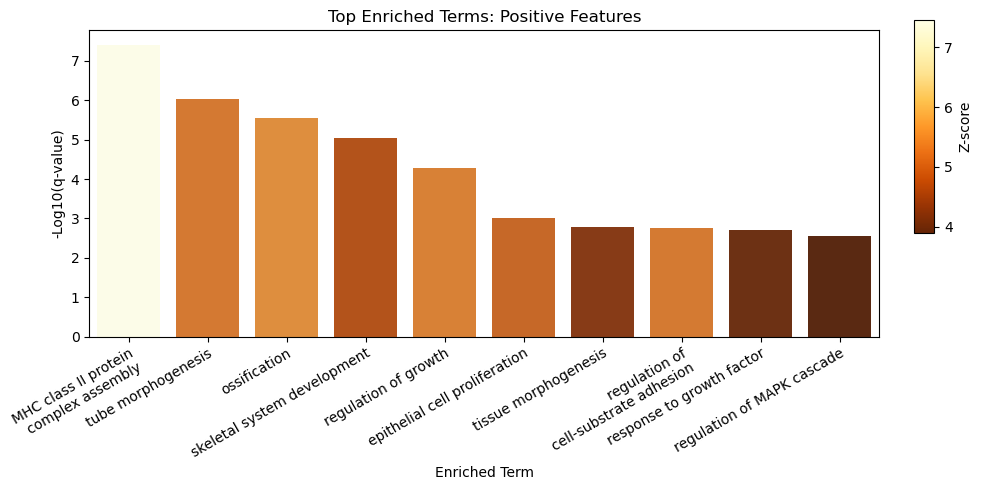

In [47]:
fig, ax = plt.subplots(figsize = (10, 5))

key = 'positive'
top_n = 10
ms = mss[key]
ms_topn = ms.iloc[:top_n, :]

if sort_by == 'zscore':
    color_col = '-Log10(q-value)'
    y_col = 'Z-score'
elif sort_by == 'pval':
    color_col = 'Z-score' 
    y_col = '-Log10(q-value)'
norm = Normalize(vmin=ms_topn[color_col].min(), vmax=ms_topn[color_col].max())
cmap = cm_matplot.get_cmap('YlOrBr_r')
colors = [cmap(norm(val)) for val in ms[color_col]]
cbar_ax = fig.add_axes([0.92, 0.525, 0.02, 0.425])  # [left, bottom, width, height]
# pos = ax.get_position()  # Returns a Bbox object
# cbar_width = 0.02  # Width of the colorbar
# cbar_padding = 0.02  # Space between subplot and colorbar
# cbar_ax = fig.add_axes([pos.x1 + cbar_padding, pos.y0, cbar_width, pos.height])  # [left, bottom, width, height]
colorbar = plt.colorbar(cm_matplot.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
colorbar.set_label(color_col)


sns.barplot(data = ms_topn, x = 'Description', y = y_col, 
            palette = colors, ax = ax)

xlabels = []
for x_label in ax.get_xticklabels():
    xlabels.append(middle_break(x_label._text, len_thresh = 35))

ax.set_xticklabels(xlabels, 
                   rotation=30, va = 'top',
                   ha="right", rotation_mode="anchor")
# ax.get_legend().remove()
ax.set_title('Top Enriched Terms: ' + key.capitalize() + ' Features')
ax.set_xlabel('Enriched Term')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar